In [1]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  

</style>

In [2]:
import datetime
import pyaurorax
import cartopy.crs
import numpy as np

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

### **Step 1: Create a Mosaic Object**

In [3]:
# download a minute of RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = start_dt
site_uid_list = ['yknf', 'gill', 'rabb', 'luck', 'atha']
data_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in the data site-by-site, as we need this separation for mosaicing
data_list = []
for site_uid, download_obj in data_download_objs.items():
    data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

In [4]:
# Get list of all skymaps in previous two years up to date of interest for each site
skymap_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(
        "TREX_RGB_SKYMAP_IDLSAV",
        start_dt.replace(year=start_dt.year - 2),
        start_dt,
        site_uid=site_uid,
    )
    skymap_download_objs[site_uid] = download_obj

# Read and store the last list index skymap for each site, as that is most recent to the date of interest
skymaps = []
for site_uid, download_obj in skymap_download_objs.items():

    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
    skymaps.append(skymap.data[0])

skymaps

[Skymap(project_uid=rgb, site_uid=yknf, imager_uid=rgb-08, site_map_latitude=62.519848, site_map_longitude=245.686966, ...),
 Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=rgb, site_uid=atha, imager_uid=rgb-07, site_map_latitude=54.602631, site_map_longitude=246.355728, ...)]

In [5]:
# prepare the skymap data
prepped_skymap = at.mosaic.prep_skymaps(skymaps, 110, n_parallel=5)

# prepare the image data
prepped_images = at.mosaic.prep_images(data_list)

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

In [6]:
# define the intensity scales for each site
scale = {
    "yknf": [10, 105],
    "gill": [10, 105],
    "rabb": [10, 105],
    "luck": [10, 105],
    "atha": [10, 105],
}

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymap, frame_num, projection_obj, image_intensity_scales=scale)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


### **Step 2: Add contours to the mosaic**

In [7]:
map_extent = [-145, -65, 35, 80]
dt = data_list[0].timestamp[0]

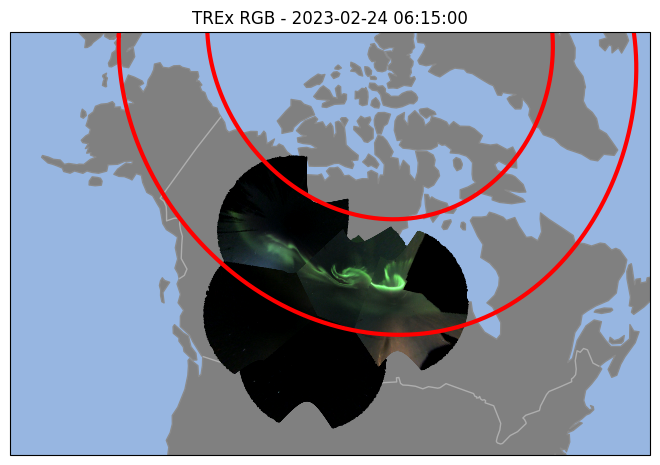

In [8]:
# First, add a couple lines of constant magnetic latitude
mosaic.add_mag_contours(dt, constant_lats=[62, 72], color='red', linewidth=3, bring_to_front=True)
# Note that the bring_to_front keyword allows for plotting on top of image data, by default contours are always behind

# Display the mosaic
mosaic.plot(map_extent, title="TREx RGB - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")))

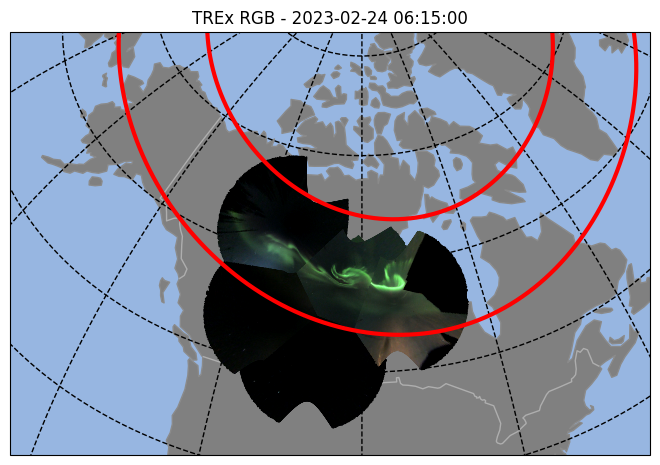

In [9]:
# Add geographic gridlines using many lines of constant lat and lon. These will go behind the image data
lat_locs = np.arange(0, 90, 10)
lon_locs = np.arange(-180, 0, 20)

mosaic.add_geo_contours(constant_lats=lat_locs, constant_lons=lon_locs, linestyle='--', color='black')

# Display the mosaic
mosaic.plot(map_extent, title="TREx RGB - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")))

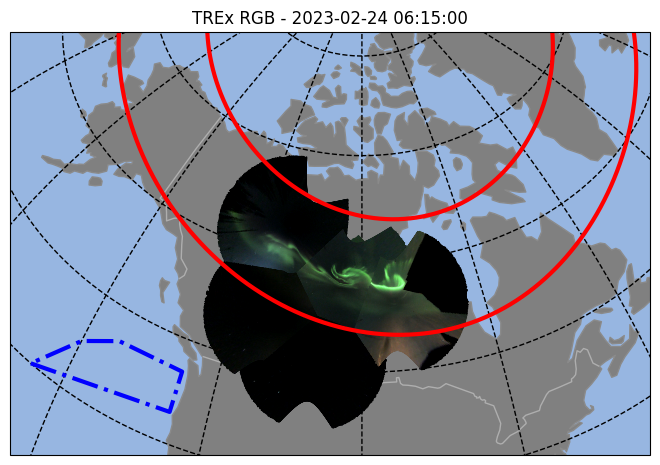

In [10]:
# Finally, we can also add contours defined by manually entering a custom set of lats and lons

# Define some contour in lat/lon space
custom_lats = [40, 43, 47, 47, 45, 40]
custom_lons = [-145, -125, -125, -135, -140, -145]

mosaic.add_geo_contours(lats=custom_lats, lons=custom_lons, linestyle='dashdot', linewidth=3, color='blue', bring_to_front=True)

# Display the mosaic
mosaic.plot(map_extent, title="TREx RGB - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")))